In [1]:
from lisainstrument import Instrument
from lisaconstants import c
import numpy as np

In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

In [4]:
import pytdi
from pytdi import Data

from pytdi.michelson import X2, Y2, Z2
from pytdi.ortho import A2, E2, T2
from pytdi.sagnac import ALPHA2, BETA2, GAMMA2,ZETA21, ZETA22, ZETA23
from pytdi.dsp import timeshift

pytdi.__version__

'1.3.dev'

In [5]:
from scipy.signal import firls,lfilter, filtfilt, welch




Switch off laser noise, clock noise, modulation error. This leaves only secondary noises (ie those not affected by TDI) and *should* give the right spectra.

- Clock noise can be switched off by calling `disable_clock_noises`
- Laser noise can be switched off by setting `laser_asds=0`
- Modulation error can be switched off by setting `modulation_asds=0`

Static orbits do almost the right thing, but we want the to have *identical* armlength, the current implementation has
```
self.pprs = ForEachMOSA({
                # Default PPRs based on first samples of Keplerian orbits (v1.0)
                '12': 8.3324, '23': 8.3028, '31': 8.3324,
                '13': 8.3315, '32': 8.3044, '21': 8.3315,
            })
```
and we need to replace that by e.g `L/c`.

In addition, make sure that both the `oms_asds` and the `testmass_asds` is the same as in the SciRD (15e12 for the inter-spacecraft carrier and 3e-15 for the TM, respectively). So we need to set
```
testmass_asds=3e-15
oms_asds=(15e-12, 1.25e-11, 1.42e-12, 3.38e-12, 3.32e-12, 7.9e-12)
```

We might also have to set `lock='six'` to make the locking scheme fully symmetric.

The easiest option might be to make a new class that inherits `Instrument` and sets all the parameters.

In [6]:
from lisainstrument.containers import ForEachMOSA, ForEachSC

class testInstrument(Instrument):
    def __init__(self, **kw):
        super().__init__( laser_asds=0, 
                          modulation_asds=0, 
                          oms_asds =(15e-12, 1.25e-11, 1.42e-12, 3.38e-12, 3.32e-12, 7.9e-12),
                          testmass_asds = 3e-15,
                          lock='six', orbits='static', **kw)
        
        self.disable_clock_noises()
        
    def init_orbits(self, orbits, orbit_dataset, tau=2.5e9/c):
       
        if orbits == 'static':
            # logger.info(f"Using default set of static proper pseudo-ranges L/c={tau}")
            self.orbit_file = None
            self.pprs = ForEachMOSA({
                # Default PPRs based on first samples of Keplerian orbits (v1.0)
                '12': tau, '23': tau, '31': tau,
                '13': tau, '32': tau, '21': tau,
            })
            self.d_pprs = ForEachMOSA(0)
            self.tps_proper_time_deviations = ForEachSC(0)
            self.orbit_dataset = None
        else:
            super().init_orbit(orbits, orbit_dataset )
            

In [7]:
%%time
dt=0.25
size=2**20
instrument = testInstrument(dt=dt, size=size)

instrument.simulate()
instrument.write(mode='w')

CPU times: user 5min 33s, sys: 2min 7s, total: 7min 40s
Wall time: 8min 42s


/Users/oliver jennrich/.conda/envs/LISA/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


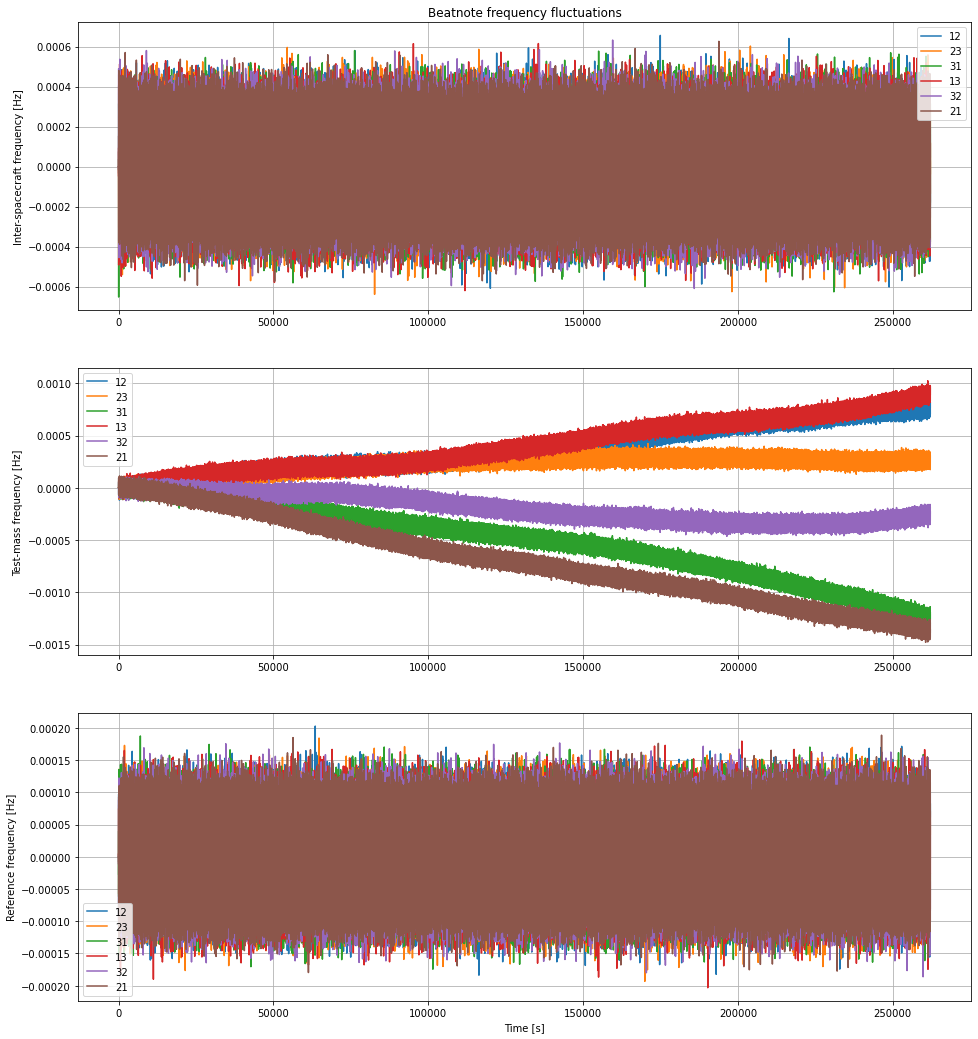

In [8]:
instrument.plot_fluctuations()

Create a dictionary with signals

In [9]:
signal={}
signal['t']= instrument.t

Create data from the instrument

In [10]:
data = Data.from_instrument(instrument)

In [11]:
names = ['X','Y','Z','A','E','T', 'α', 'β', 'γ', 'ζ_1', 'ζ_2', 'ζ_3']
signals = [X2,Y2,Z2, A2,E2,T2, ALPHA2, BETA2, GAMMA2, ZETA21, ZETA22, ZETA23]

In [12]:
%%time
for k, (p,name) in enumerate( zip(signals , names)):
    built=p.build(**data.args)
    s = built(data.measurements)
    signal[name] =  s
    coldf = pd.DataFrame( np.array([instrument.t, s]).T, columns=['time',name])
    coldf.to_csv(f'signal_{name}.csv')

CPU times: user 30min 11s, sys: 9min 44s, total: 39min 56s
Wall time: 40min 24s


Write the unfiltered signals to be able to save time next time around

Build the filter to get rid of the HF contributions

In [13]:
fir_firls= firls(241, (0,  0.5, 1, 2), (1, 1, 1e-8, 1e-14), fs=1/instrument.dt)

signal_filt={}
for k,v in signal.items():
    if k != 't':
        s = filtfilt(fir_firls, [1.0], v)
        signal_filt[k] = s
        coldf = pd.DataFrame( np.array([instrument.t, s]).T, columns=['time',k])
        coldf.to_csv(f'signal_{k}_filt.csv')

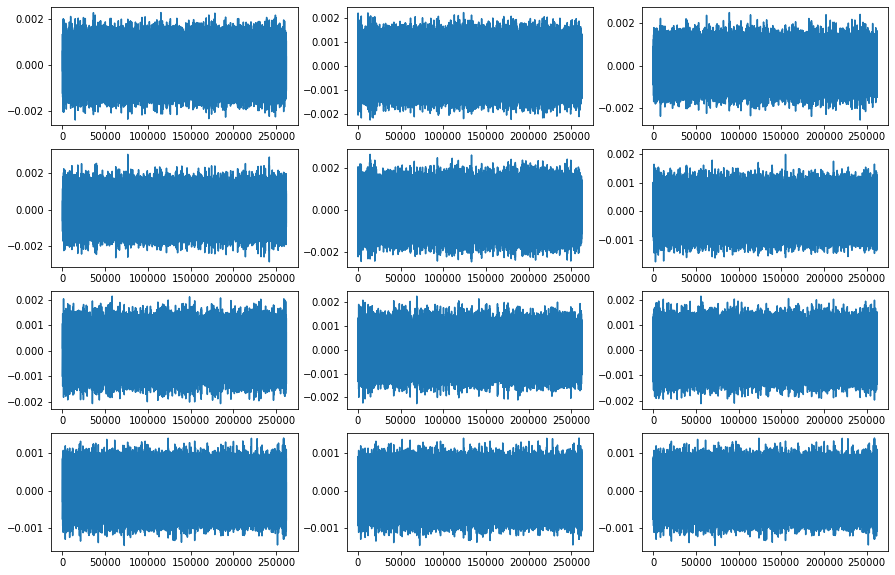

In [14]:
fig, ax = plt.subplots( ncols=3, nrows=4, figsize=(15,10))
skip =200
for k, (sk, sv ) in enumerate( signal_filt.items() ):
    ax[ k//3, k%3].plot( instrument.t[skip:-skip], sv[skip:-skip])

In [15]:
signal_psd={}

def nuttall4(point):
    coeffs = [0.3125, -0.46875, 0.1875, -0.03125]
    args = 2 * np.pi * point * np.arange(0, len(coeffs))
    terms = coeffs * np.cos(args)
    return np.sum(terms)

nperseg = 2**16
win = [nuttall4(i) for i in np.arange(0, 1, 1 / nperseg)]
for k, (sk, sv ) in enumerate( signal_filt.items() ):
    if sk !='t':
        signal_psd[sk] = welch(sv[skip:-skip], fs=1/instrument.dt, window=win, 
              nperseg=nperseg, noverlap=None, nfft=None, 
              detrend=False, return_onesided=True, 
              scaling='density', axis=- 1, average='mean')

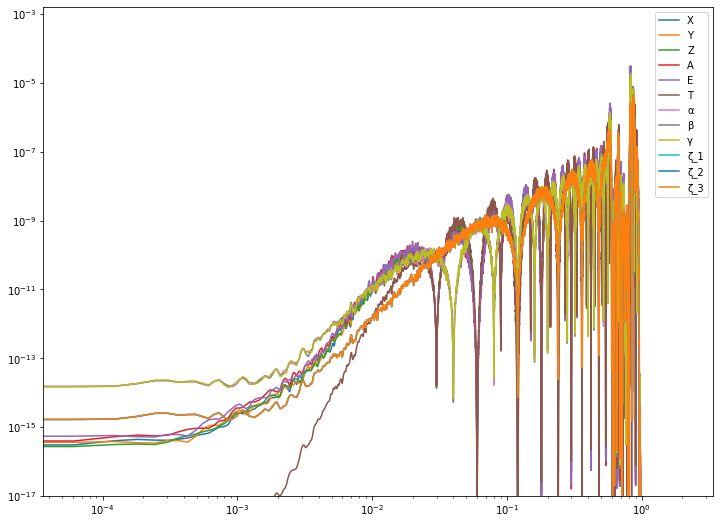

In [16]:
fig,ax = plt.subplots( figsize=(12,9))
                
for k,v in signal_psd.items():
        ax.loglog(*v, label=k)
                       
ax.set_ylim([ 1e-17, ax.get_ylim()[1]])
ax.legend()


Sanity check - the integral over the PSD should be the variance of the time series

In [17]:
for k in signal_psd.keys():
    print( f"{k} : {1- np.trapz( signal_psd[k][1],signal_psd[k][0] )/np.var(signal_filt[k] ) }")

X : 0.012321560270342813
Y : 0.010372684655379438
Z : -0.02212228308043329
A : -0.005781016874747413
E : 0.005675638915936254
T : 0.0018012826544914207
α : -0.004090673769469477
β : -0.009747883678207891
γ : 0.011255994844347805
ζ_1 : 0.006125291779959574
ζ_2 : 0.006125291058054372
ζ_3 : 0.0061252915897214155


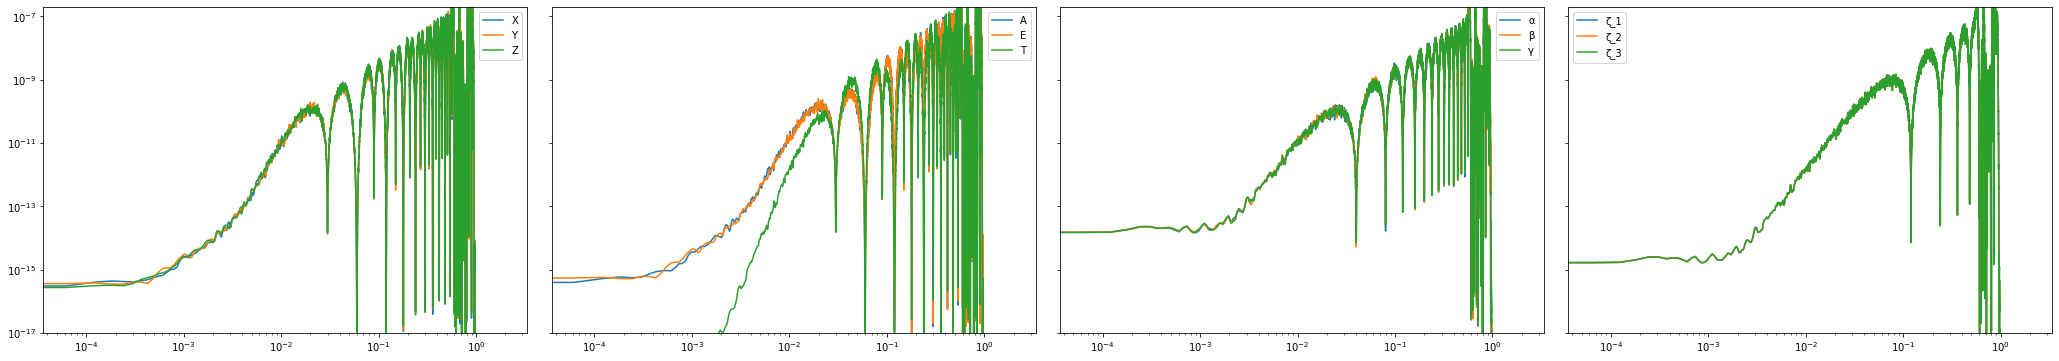

In [18]:
fig,ax = plt.subplots( ncols = 4, figsize=(36,6), sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0)
                
for j,(k,v) in enumerate(signal_psd.items()):
    axx = ax[j//3]
    axx.loglog(*v, label=k)
                       
    axx.legend()
    axx.set_ylim([ 1e-17, 2e-7])

Are the X,Y,Z channels identical? Or the A and E channels?

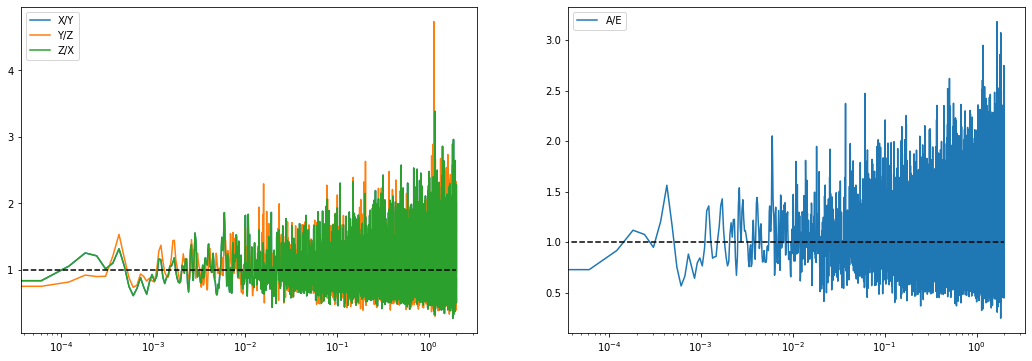

In [19]:
fig,(ax,bx) = plt.subplots( ncols=2, figsize=(18,6))
ax.plot( signal_psd['X'][0], signal_psd['X'][1]/signal_psd['Y'][1], label='X/Y')
ax.plot( signal_psd['Y'][0], signal_psd['Z'][1]/signal_psd['Y'][1], label='Y/Z')
ax.plot( signal_psd['Z'][0], signal_psd['X'][1]/signal_psd['Y'][1], label='Z/X')
ax.hlines(1, signal_psd['X'][0][0],signal_psd['X'][0][-1], color='k', linestyle='--')
ax.set_xscale('log')
ax.legend()

bx.plot( signal_psd['A'][0], signal_psd['A'][1]/signal_psd['E'][1], label='A/E')
bx.hlines(1, signal_psd['X'][0][0],signal_psd['X'][0][-1], color='k', linestyle='--')
bx.set_xscale('log')
bx.legend()


In [94]:
def psd_tdi(f, channel='X', L=2.5e9, s_oms = 15e-12, s_acc = 3e-15):
    def C(x):
        return 16*np.sin(x)**2*np.sin(2*x)**2
    
    def C1(x):
        return 16*np.sin(3/2*x)**2
    
    def C2(x):
        return 16*np.sin(x/2)**2
    
    w = 2*np.pi*f
    x=w*L/c
    lam = 1.064e-6 
    
    # keep in mind that we are looking at frequency fluctuations  
    # df = d \dot phi = \dot (dx/lambda) = w*dx/lambda
    
    dx_to_dnu = (w/lam)
    
    # The Otpical Metrology Noise (OMS) has a frequency shape factor that 
    # allows a ramp-up of the noise for low frequency. That is not necessarily a 
    # prediction of the behaviour, but more a relaxation factor.
    # It relaxes at 2mHz which is about the point where LISA's sensitivity is dominated
    # by acceleration noise anyway. So there is no need to be ultra-strict with the 
    # requirements.
    
    S_oms = s_oms**2 * (1. + (2.e-3/f)**4)
    S_oms_nu = S_oms*dx_to_dnu**2
    
    # The acceleration noise (ACC) has two shaping factors. One at 
    # 8mHz where it is allowed to rise up, as at that frequency we are dominated by
    # OMS noise anyway, so no need to be strict at high frequencies
    #
    # The other factor *reddends* the noise below 0.4mHz. This is more relevant as
    # it assumes that at low frequencies we find some effects that make the acceleration noise worse.
    # Additional shaping factors at lower frequencies are possible, but are not covered in the 
    # Science Requirements.
    
    S_acc= s_acc**2 * (1.0 +(0.4e-3/f)**2)*(1.0+(f/8e-3)**4)
    S_acc_nu = S_acc*dx_to_dnu**2
    
    # we only implement the H_1 and H2 terms here (see Antoines note)
    if channel in ['X','Y','Z']:
        return 4*C(x)*( S_oms_nu+ (3+np.cos(2*x))*S_acc_nu/(w**4))
    elif  channel in ['A','E']:
        return 2*C(x) * ( ( 2+np.cos(x))*S_oms_nu + 2*( ( 3+2*np.cos(x) + np.cos(2*x) ) )*S_acc_nu/(w**4) )
    elif  channel in ['T']:
        return 4*C(x)*( (1-np.cos(x))*S_oms_nu +  8*np.sin(0.5*x)**4*S_acc_nu/(w**4) )
    elif channel in ['α', 'β', 'γ']:
        # guesswork
        return 2*C1(x) * (1/np.sqrt(2)*S_oms_nu+ np.sin(x)**2*(3+np.cos(2*x))*S_acc_nu/(w**4))
    elif channel in ['ζ_1', 'ζ_2', 'ζ_3']:
        # guesswork
        return 2*C2(x) * (1/np.sqrt(2)*S_oms_nu+ np.sin(x)**2*(3+np.cos(2*x))*S_acc_nu/(w**4))
    else: 
        assert False, "Only channel X,Y,Z, or  A, E, T are currently implemented"

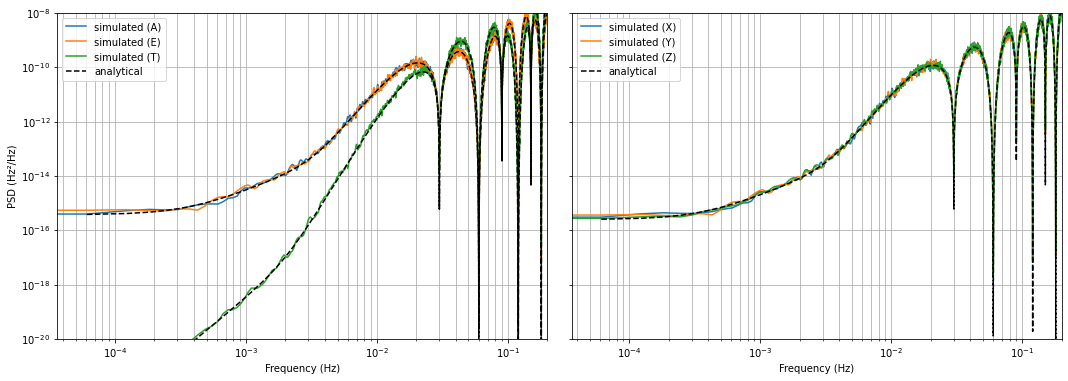

In [103]:
fig, (ax,cx) = plt.subplots( ncols=2, figsize=(18,6), sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0)

ff = signal_psd['A'][0][1:]
s_oms=instrument.oms_isc_carrier_asds['12']
s_acc=instrument.testmass_asds['12']

ax.loglog(*signal_psd['A'], label = 'simulated (A)')
ax.loglog(*signal_psd['E'], label = 'simulated (E)')
ax.loglog(*signal_psd['T'], label = 'simulated (T)')
ax.loglog(ff, psd_tdi( ff, channel='T', s_oms=s_oms, s_acc=s_acc), color='k', linestyle='--')
ax.loglog(ff, psd_tdi( ff, channel='A', s_oms=s_oms, s_acc=s_acc), label='analytical', color='k', linestyle='--')
ax.legend()
ax.set_ylim([ 1e-20, 1e-8])
ax.set_xlim( [ax.get_xlim()[0],0.2])
ax.grid(which='both')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel(r'PSD (Hz²/Hz)')

cx.loglog(*signal_psd['X'], label = 'simulated (X)')
cx.loglog(*signal_psd['Y'], label = 'simulated (Y)')
cx.loglog(*signal_psd['Z'], label = 'simulated (Z)')
cx.loglog(ff, psd_tdi( ff, channel='X', s_oms=s_oms, s_acc=s_acc), label='analytical', color='k', linestyle='--')
cx.legend()
#cx.set_ylim([ 1e-16,1e-8])
cx.set_xlim( [cx.get_xlim()[0],0.2])
cx.grid(which='both')
cx.set_xlabel('Frequency (Hz)')

plt.savefig( 'plots/sim_vs_ana.pdf')

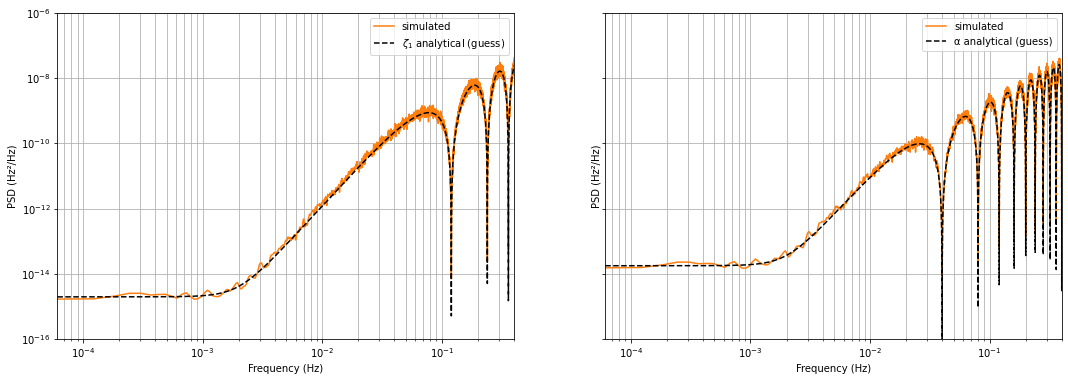

In [105]:
fig,(ax,cx) = plt.subplots( ncols=2, figsize=(18,6), sharey=True)
ax.loglog( *signal_psd['ζ_1'], color='C1',label='simulated')
ax.loglog( ff, psd_tdi( ff, channel='ζ_1', s_oms=s_oms, s_acc=s_acc),label=r'$\zeta_1$ analytical (guess)', color='k', linestyle='--')
ax.set_ylim([1e-16,1e-6])
ax.set_xlim([ff[0],0.4])
ax.grid(which='both')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel(r'PSD (Hz²/Hz)')

ax.legend()

cx.loglog( *signal_psd['α'], color='C1',label='simulated')
cx.loglog( ff, psd_tdi( ff, channel='α', s_oms=s_oms, s_acc=s_acc),label='α analytical (guess)', color='k', linestyle='--')
#cx.set_ylim([1e-16,1e-6])
cx.set_xlim([ff[0],0.4])
cx.grid(which='both')
cx.set_xlabel('Frequency (Hz)')
cx.set_ylabel(r'PSD (Hz²/Hz)')

cx.legend()